# Program Header

In [171]:
import pandas as pd
import numpy as np
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from header import *

In [172]:
data_root = initialize_data_root("AY")

In [173]:
import difflib
import jellyfish
import fuzzywuzzy
from fuzzywuzzy import process

# Table of contents
1. [Import](#Import)
2. [Create Tag Map](#CreateTagMap)
5. [Save](#Save)

## Import <a name="Import"></a>

In [302]:
raw_sec_data = pd.read_csv(data_root+'02-build/clean/2019q3/sec_data_long.csv')
raw_custom_tag_map = pd.read_csv(data_root+'02-build/clean/2019q3/custom_tag_map.csv')

In [175]:
sec_data = raw_sec_data.copy()

In [307]:
custom_tag_map = raw_custom_tag_map.rename({'raw_tag':'tag'}, axis = 'columns')

## Create Tag Map <a name="CreateTagMap"></a>

Let's define a tag's reach as the percent of companies seen that include the tag. The name of creating a tag map and consolidating raw tags is to improve the average reach.

In [208]:
def get_tag_reach(tag):
    total = sec_data.['tag'].isin([tag])
    return(sum(total)/len(sec_data.adsh.unique()))

In [284]:
all_tags = sec_data.tag.unique()

In [291]:
tag_view = sec_data.groupby('tag').nunique()['adsh'].sort_values()/len(sec_data.adsh.unique())

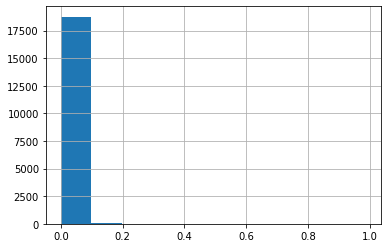

In [293]:
tag_view.hist()

Let's define a `common tag` as a tag with reach of at least 10%. We've already gone through all 149 common tags and consolidated them.

In [294]:
common_tags = tag_view.loc[tag_view >= 0.1]

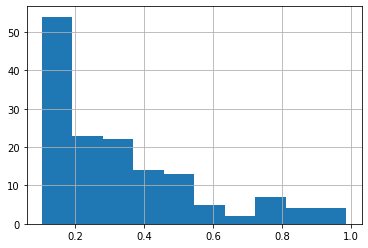

In [295]:
common_tags.hist()

In [314]:
cleaned_sec = sec_data.merge(custom_tag_map, on = ['tag'])
clean_tag_view = cleaned_sec.groupby('clean_tag').nunique()['adsh'].sort_values()/len(cleaned_sec.adsh.unique())

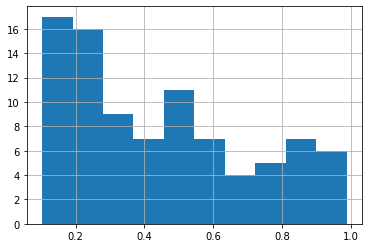

In [315]:
clean_tag_view.hist()

So we see that our manual matching process has dramatically improved coverage among the common tags. Now, let's use fuzzywuzzy to classify less column tags as part of the common tags:

In [177]:
def find_contain_matches(tag, tag_list):
    matching_tags = sec_data['tag'].str.contains(tag)
    return(sec_data['tag'].loc[matching_tags].unique())

In [227]:
def view_all_tags_for_company(adsh = ""):
    if adsh == "":
        adsh = sec_data.adsh.sample(1).values[0]
    company_name = sec_data.loc[sec_data.adsh == adsh].company_name.unique()
    tags = sec_data.loc[sec_data.adsh == adsh].tag.unique()
    return((company_name,tags))

In [317]:
def find_fuzzy_matches(tag):
    fuzzy_matches = process.extract(tag, sec_data['tag'].unique())
    matches = [[i[0] for i in list] for list in fuzzy_matches]
    return(matches)

Let's create dictionaries of tags starting from the most common:

In [277]:
tag_occurence = sec_data.tag.value_counts()/len(sec_data.adsh.unique())
tag_occurence = tag_occurence.loc[tag_occurence > 0.10]

In [278]:
len(tag_occurence)

148

In [280]:
tag_occurence.to_csv(data_root+"02-build/raw/common_tags.csv")

C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [273]:
matches = find_fuzzy_matches(['Marketing','GeneralAdministrative'])
matches

array(['MarketingAndAdvertisingExpense', 'SellingAndMarketingExpense',
       'AccruedMarketingCostsCurrent', 'MarketingExpense',
       'BusinessDevelopmentAndMarketingExpense',
       'SellingGeneralAdministrativeExpenseAsPercentNetSales',
       'GeneralAdministrativeAndOtherExpenses',
       'GeneralAdministrativeAndOtherExpense',
       'GeneralAdministrativeAndOccupancy',
       'GeneralAndAdministrativeExpense'], dtype='<U52')

In [272]:
get_tag_reach(matches)

0.6370562770562771

In [243]:
get_tag_reacheach(matches)

0.30787878787878786

In [233]:
view_all_tags_for_company()

(array(['GENERAL MILLS INC'], dtype=object), array(['AccountsPayableCurrent',
        'AccumulatedOtherComprehensiveIncomeLossCumulativeChangesInNetGainLossFromCashFlowHedgesEffectNetOfTax',
        'AccumulatedOtherComprehensiveIncomeLossForeignCurrencyTranslationAdjustmentNetOfTax',
        'AccumulatedOtherComprehensiveIncomeLossNetOfTax',
        'AdditionalPaidInCapitalCommonStock',
        'AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue',
        'AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount',
        'Assets', 'AssetsCurrent', 'CashAndCashEquivalentsAtCarryingValue',
        'CashAndCashEquivalentsPeriodIncreaseDecrease',
        'CommonStockDividendsPerShareCashPaid',
        'CommonStockDividendsPerShareDeclared',
        'CommonStockParOrStatedValuePerShare',
        'CommonStockSharesAuthorized', 'CommonStockSharesIssued',
        'CommonStockValue', 'ComprehensiveIncomeNetOfTax',
        'Comprehensi

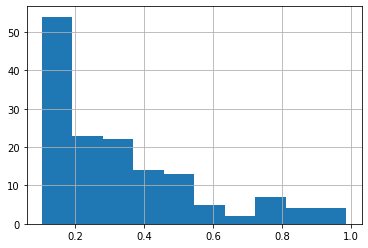

In [74]:
common_tags.hist()

Since the cutoff seems to be at 0.2, let's set the common tags to be above that:

In [114]:
medium_tags = tag_occurence.loc[(tag_occurence > 0.2)&(tag_occurence < 0.7)].index

Let's make dictionaries of tags now:

In [125]:
tag_map = {}

In [126]:
for i in medium_tags:
    matches = find_fuzzy_matches(i)
    tag_map[i] = matches

We'll convert these dictionary tag maps to a data-frame to easily use SQL-style joins.

In [127]:
tag_map_df = pd.DataFrame(columns = ['clean_tag', 'tag'])
tag_map_df

,clean_tag,tag


In [128]:
map_df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in tag_map.items()]))\
            .melt()\
            .dropna()\
            .rename({'variable':'clean_tag', 'value':'tag'}, axis = 'columns')

In [129]:
map_df

,clean_tag,tag
0,IncomeTaxExpenseBenefit,IncomeTaxExpenseBenefit
1,IncomeTaxExpenseBenefit,IncomeTaxExpenseBenefitCity
2,IncomeTaxExpenseBenefit,TaxCutsAndJobsActOf2017IncomeTaxExpenseBenefit
3,IncomeTaxExpenseBenefit,StateAndLocalIncomeTaxExpenseBenefitContinuing...
4,IncomeTaxExpenseBenefit,DeferredFederalIncomeTaxExpenseBenefit
5,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AccumulatedOtherComprehensiveIncomeLossNetOfTax
6,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AccumulatedOtherComprehensiveIncomeLossOtherNe...
7,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AccumulatedOtherComprehensiveIncomeLossTax
8,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AccumulatedOtherComprehensiveIncomeLossBeforeTax1
9,AccumulatedOtherComprehensiveIncomeLossNetOfTax,OtherComprehensiveIncomeLoss


In [154]:
for i,j in tag_map.items():
    print(i,"%.2f %.2f"%(round(get_tag_reach([i]),2), round(get_tag_reach(j),2)))

IncomeTaxExpenseBenefit 0.75 0.75
AccumulatedOtherComprehensiveIncomeLossNetOfTax 0.60 2.71
OperatingLeaseRightOfUseAsset 0.59 0.59
OperatingLeaseLiability 1.94 1.94
AccountsPayableCurrent 0.60 0.67
ComprehensiveIncomeNetOfTax 0.90 0.90
WeightedAverageNumberOfSharesOutstandingBasic 0.54 2.81
PreferredStockSharesAuthorized 0.54 0.54
InterestExpense 1.10 1.27
WeightedAverageNumberOfDilutedSharesOutstanding 0.53 2.49
EarningsPerShareBasic 0.87 0.87
EarningsPerShareDiluted 0.51 0.51
OtherAssetsNoncurrent 0.52 6.58
AccountsReceivableNetCurrent 0.50 0.51
AdditionalPaidInCapital 1.47 1.47
PreferredStockParOrStatedValuePerShare 0.48 0.48
Goodwill 1.10 1.10
CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents 0.66 0.66
OperatingLeaseLiabilityCurrent 0.46 0.92
OperatingLeaseLiabilityNoncurrent 0.46 0.92
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest 0.45 1.08
OperatingExpenses 0.47 0.52
AccumulatedDepreciationDepletionAndAmortizationPropertyP

In [17]:
print("Consolidated ",round((1-len(tag_map_df.clean_tag.unique())/len(tag_map_df.tag.unique()))*100,2),"% of tags", sep = "")

Consolidated 78.11% of tags


In addition to the algorithm, we use domain knowledge to add in exceptions.

## Web Scraping Yahoo Finance

In [156]:
def periodic_figure_values(soup, yahoo_figure):

    values = []
    pattern = re.compile(yahoo_figure)

    title = soup.find("strong", text=pattern)    # works for the figures printed in bold
    if title:
        row = title.parent.parent
    else:
        title = soup.find("td", text=pattern)    # works for any other available figure
        if title:
            row = title.parent
        else:
            sys.exit("Invalid figure '" + yahoo_figure + "' passed.")

    cells = row.find_all("td")[1:]    # exclude the <td> with figure name
    for cell in cells:
        if cell.text.strip() != yahoo_figure:    # needed because some figures are indented
            str_value = cell.text.strip().replace(",", "").replace("(", "-").replace(")", "")
            if str_value == "-":
                str_value = 0
            value = int(str_value) * 1000
            values.append(value)

    return values

def financials_soup(ticker_symbol, statement="is", quarterly=False):

    if statement == "is" or statement == "bs" or statement == "cf":
        url = "https://finance.yahoo.com/q/" + statement + "?s=" + ticker_symbol
        if not quarterly:
            url += "&annual"
        return BeautifulSoup(requests.get(url).text, "html.parser")

    return sys.exit("Invalid financial statement code '" + statement + "' passed.")

In [167]:
from bs4 import BeautifulSoup
import requests

myurl = "https://finance.yahoo.com/q/is?s=AAPL&annual"
html = requests.get(myurl).content
soup = BeautifulSoup(html)

In [168]:
import re

In [170]:
print(periodic_figure_values(financials_soup("AAPL", "is"), "Revenue"))

SystemExit: Invalid figure 'Revenue' passed.

## Save <a name="Save"></a>
Save tag map to build/clean

In [20]:
# Save
tag_map_df.to_csv(data_root+'02-build/clean/2019q3/tag_map.csv', index = False)